In [54]:
import importlib
import src.data_preparation
import src.network
import src.criterion
importlib.reload(src.data_preparation)
importlib.reload(src.network)
importlib.reload(src.criterion)

from src.data_preparation import *
from src.network import *
import sys

from tqdm import tqdm

from src.criterion import *

<Figure size 640x480 with 0 Axes>

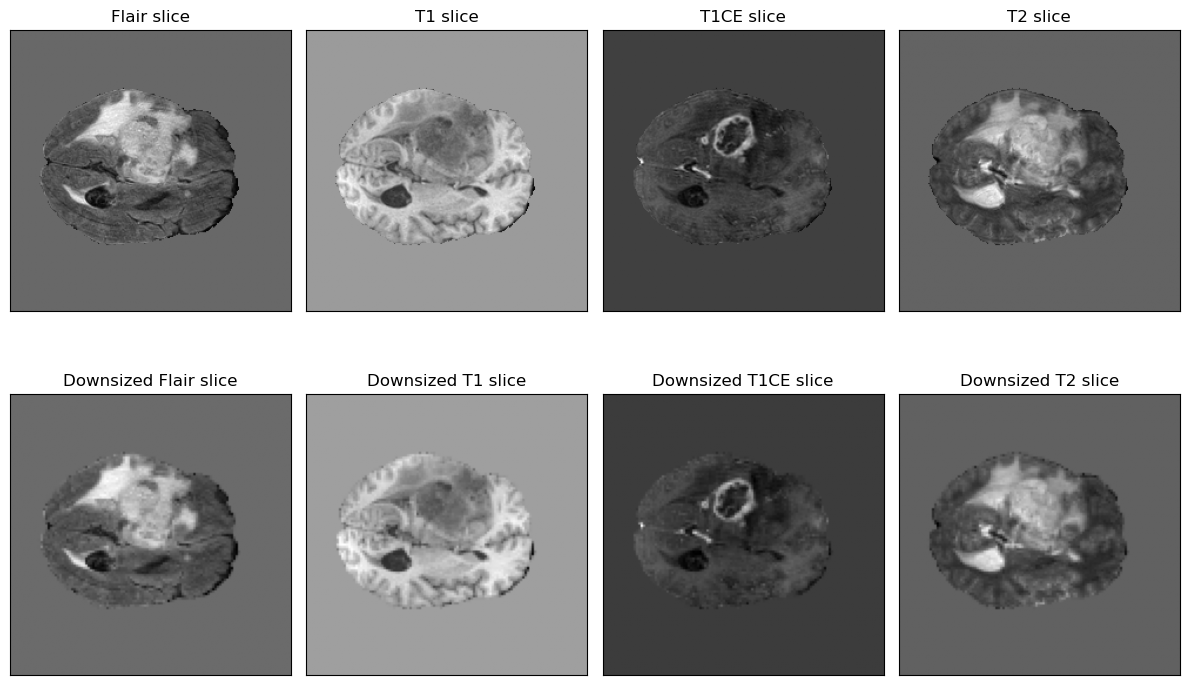

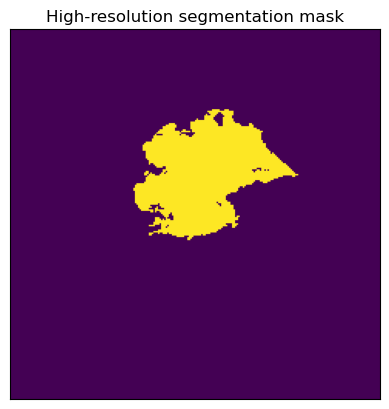

In [55]:
TRAIN_DATASET_PATH = '../BRATS20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '../BRATS20/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_dataset = BRATS_dataset(TRAIN_DATASET_PATH, device, num_slices = 3, ds_ratio = 2, downsamp_type = 'bilinear')
test_loader = DataLoader(test_dataset, batch_size=1)
iter_loader = iter(test_loader)

idx = 70

img_list, ds_img_list, mask = test_dataset[70]
    
img_labels = ["Flair", "T1", "T1CE", "T2"]

#Plot an example

plt.gray()
fig,ax = plt.subplots(2,4, figsize=(12,8))

for j in range(4):
    ax[0,j].imshow(img_list[j][1,:,:].squeeze().cpu().detach())
    ax[0,j].set_title(img_labels[j] + " slice")
    ax[1,j].imshow(ds_img_list[j][1,:,:].squeeze().cpu().detach())
    ax[1,j].set_title("Downsized " + img_labels[j] + " slice")
    

for ax in fig.get_axes():
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='x', length=0)
    ax.tick_params(axis='y', length=0)
    
fig.tight_layout()
fig.show()

plt.figure()
plt.imshow(mask.cpu().detach(), cmap = 'viridis')
plt.title("High-resolution segmentation mask")
plt.xticks([])
plt.yticks([])
plt.show()


In [56]:

from torch.optim.lr_scheduler import LambdaLR

num_classes = 2
num_slices = 3
model = VAE_UNET(num_slices, input_dim=test_dataset.input_dim, HR_dim=test_dataset.output_dim, num_classes=num_classes)
model = model.to(device)

train_loader = DataLoader(test_dataset, batch_size=5)

learning_rate = 1e-4
num_epochs = 10

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 1e-5)

# Scheduler
lr_lambda = lambda epoch: (1 - epoch / num_epochs) ** 0.9
scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

criterion = combined_loss


In [58]:
def test_model(model, test_loader):
    
    model.eval()
    test_bar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]")
    metrics = np.zeros((3,))
    
    with torch.no_grad:
    
        for img_list, ds_img_list, mask in test_bar:

            mask = mask.unsqueeze(1)
            central_slice = img_list[0][:,1,:,:].unsqueeze(1)

            seg_out, vae_out, mu, logvar = model(ds_img_list[0])

            metrics[0] += soft_dice_loss(seg_out, seg_target.long()) 
            metrics[1] += MSE_loss(vae_out, vae_target)
            metrics[2] += kl_loss(mu, logvar)
        
    metrics = metrics / len(test_bar)
    
    print(f"--- DICE: {metrics[0]:3f}, MSE: {metrics[1]:3f}, KL {metrics[2]:3f}")
    
    return metrics
    
    

In [57]:
#Scheduler
#Augementation

validation = True

for epoch in range(num_epochs):
    
    model.train()
    running_loss = 0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
    i = 0
    
    for img_list, ds_img_list, mask in train_bar:
        
        mask = mask.unsqueeze(1)
        central_slice = img_list[0][:,1,:,:].unsqueeze(1)

        optimizer.zero_grad()
        seg_out, vae_out, mu, logvar = model(ds_img_list[0])
        
        loss = criterion(seg_out, mask.long(), vae_out, central_slice, mu, logvar)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())
        
    if(validation):
  
    
    scheduler.step() # Call after each epoch


Epoch 1/10 [Training]:   2%|▏         | 185/11292 [01:25<1:25:36,  2.16it/s, loss=0.00515]


KeyboardInterrupt: 